In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import koreanize_matplotlib
import seaborn as sns
from scipy import stats

import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import warnings

In [2]:
from sklearn.metrics import make_scorer

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    return rmsle(y, pred)

scores = make_scorer(evaluate_regr)

In [3]:
warnings.filterwarnings('ignore')
# 노트북 안에 그래프를 그리기 위해
%matplotlib inline
plt.style.use('ggplot') # 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
mpl.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처

RANDOM_STATE = 110
pd.set_option('display.max_columns', None)

train_df = pd.read_csv("../../data/bike/train.csv", parse_dates=['datetime'])
test_df = pd.read_csv("../../data/bike/test.csv", parse_dates=['datetime'])
santander_submission_df = pd.read_csv("../../data/bike/sampleSubmission.csv")

> - 2011년 1월 ~ 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안 자전거 대여 횟수 데이터가 있다.

> - datetime: hourly date + timestamp
> - season: 1 - 봄, 2 - 여름, 3- 가을, 4 - 겨울
> - holyday: 1 - 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 - 휴일이 아닌 날
> - workingday: 1 - 토, 일요일의 주말 및 휴일이 아닌 주중, 0 - 주말 및 휴일
> - weather:
> - - 1 = 맑음, 약간 구름 낀 흐림 / 2 = 안개, 안개 + 흐림 / 3 = 가벼운 눈, 가벼운 비 + 천둥 / 4 = 심한 눈/비, 천둥/번개
> - temp: 온도(섭씨)
> - atemp: 체감 온도(섭씨)
> - humidity: 상대 습도
> - windspeed: 풍속
> - casual: 사전에 등록되지 않은 사용자가 대여한 횟수
> - registered: 사전에 등록된 사용자가 대여한 횟수
> - count: 대여 횟수

### feature 탐색

In [4]:
train_df.shape

(10886, 12)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [6]:
train_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [7]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
train_df.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [10]:
# test_df에는 casual, registered, count가 없다.

### 시각화

In [11]:
train_df['year'] = train_df.datetime.apply(lambda x: x.year)
train_df['month'] = train_df.datetime.apply(lambda x: x.month)
train_df['day'] = train_df.datetime.apply(lambda x: x.day)
train_df['hour'] = train_df.datetime.apply(lambda x: x.hour)
# # train_df["dayofweek"] = train_df["datetime"].dt.dayofweek

# test_df['year'] = test_df.datetime.apply(lambda x: x.year)
# test_df['month'] = test_df.datetime.apply(lambda x: x.month)
# test_df['day'] = test_df.datetime.apply(lambda x: x.day)
# test_df['hour'] = test_df.datetime.apply(lambda x: x.hour)
# # test_df["dayofweek"] = test_df["datetime"].dt.dayofweek

# train_df.drop(['datetime'], axis=1, inplace=True)
# test_df.drop(['datetime'], axis=1, inplace=True)

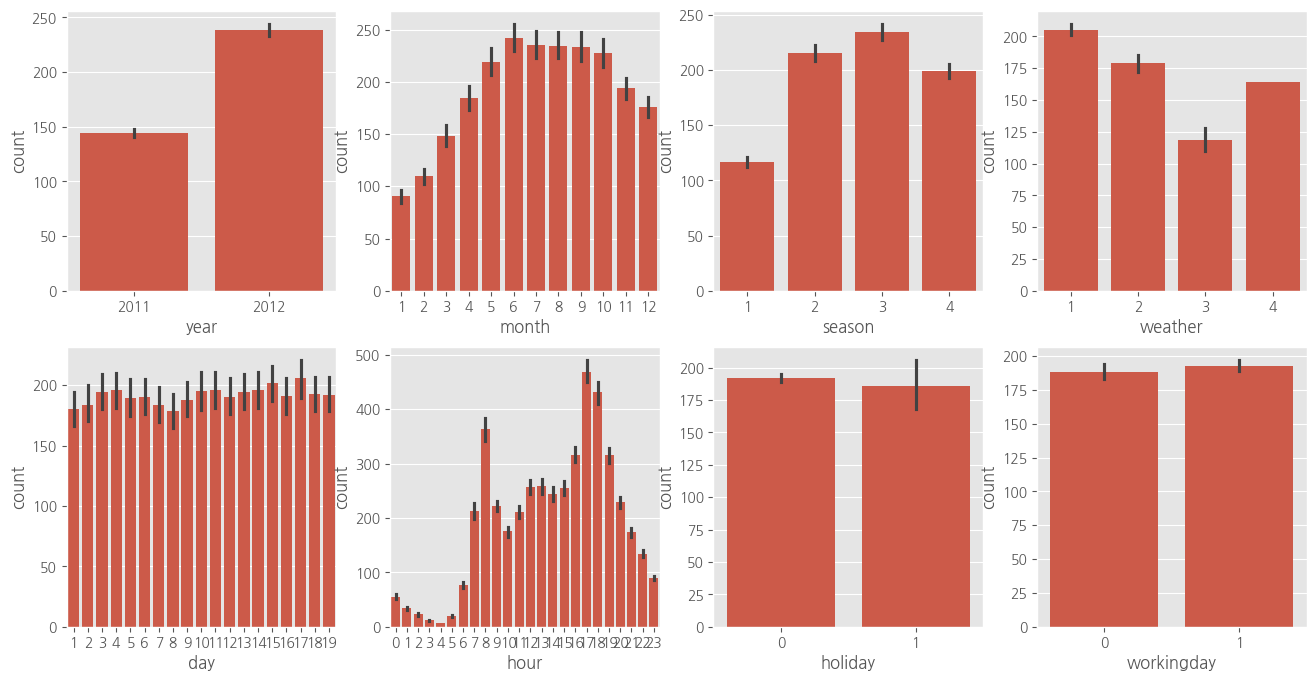

In [12]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']

for i, feature in enumerate(features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data=train_df, ax=axs[row][col])

> - 연도별 대여량은 2011년 보다 2012년이 더 많다.
> - 월 별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.
> - 일 별 대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 피처로 사용하면 안 된다.
> - 시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.
> - 분, 초도 다 0이기 때문에 의미가 없다. -> 생략

<Axes: xlabel='hour', ylabel='count'>

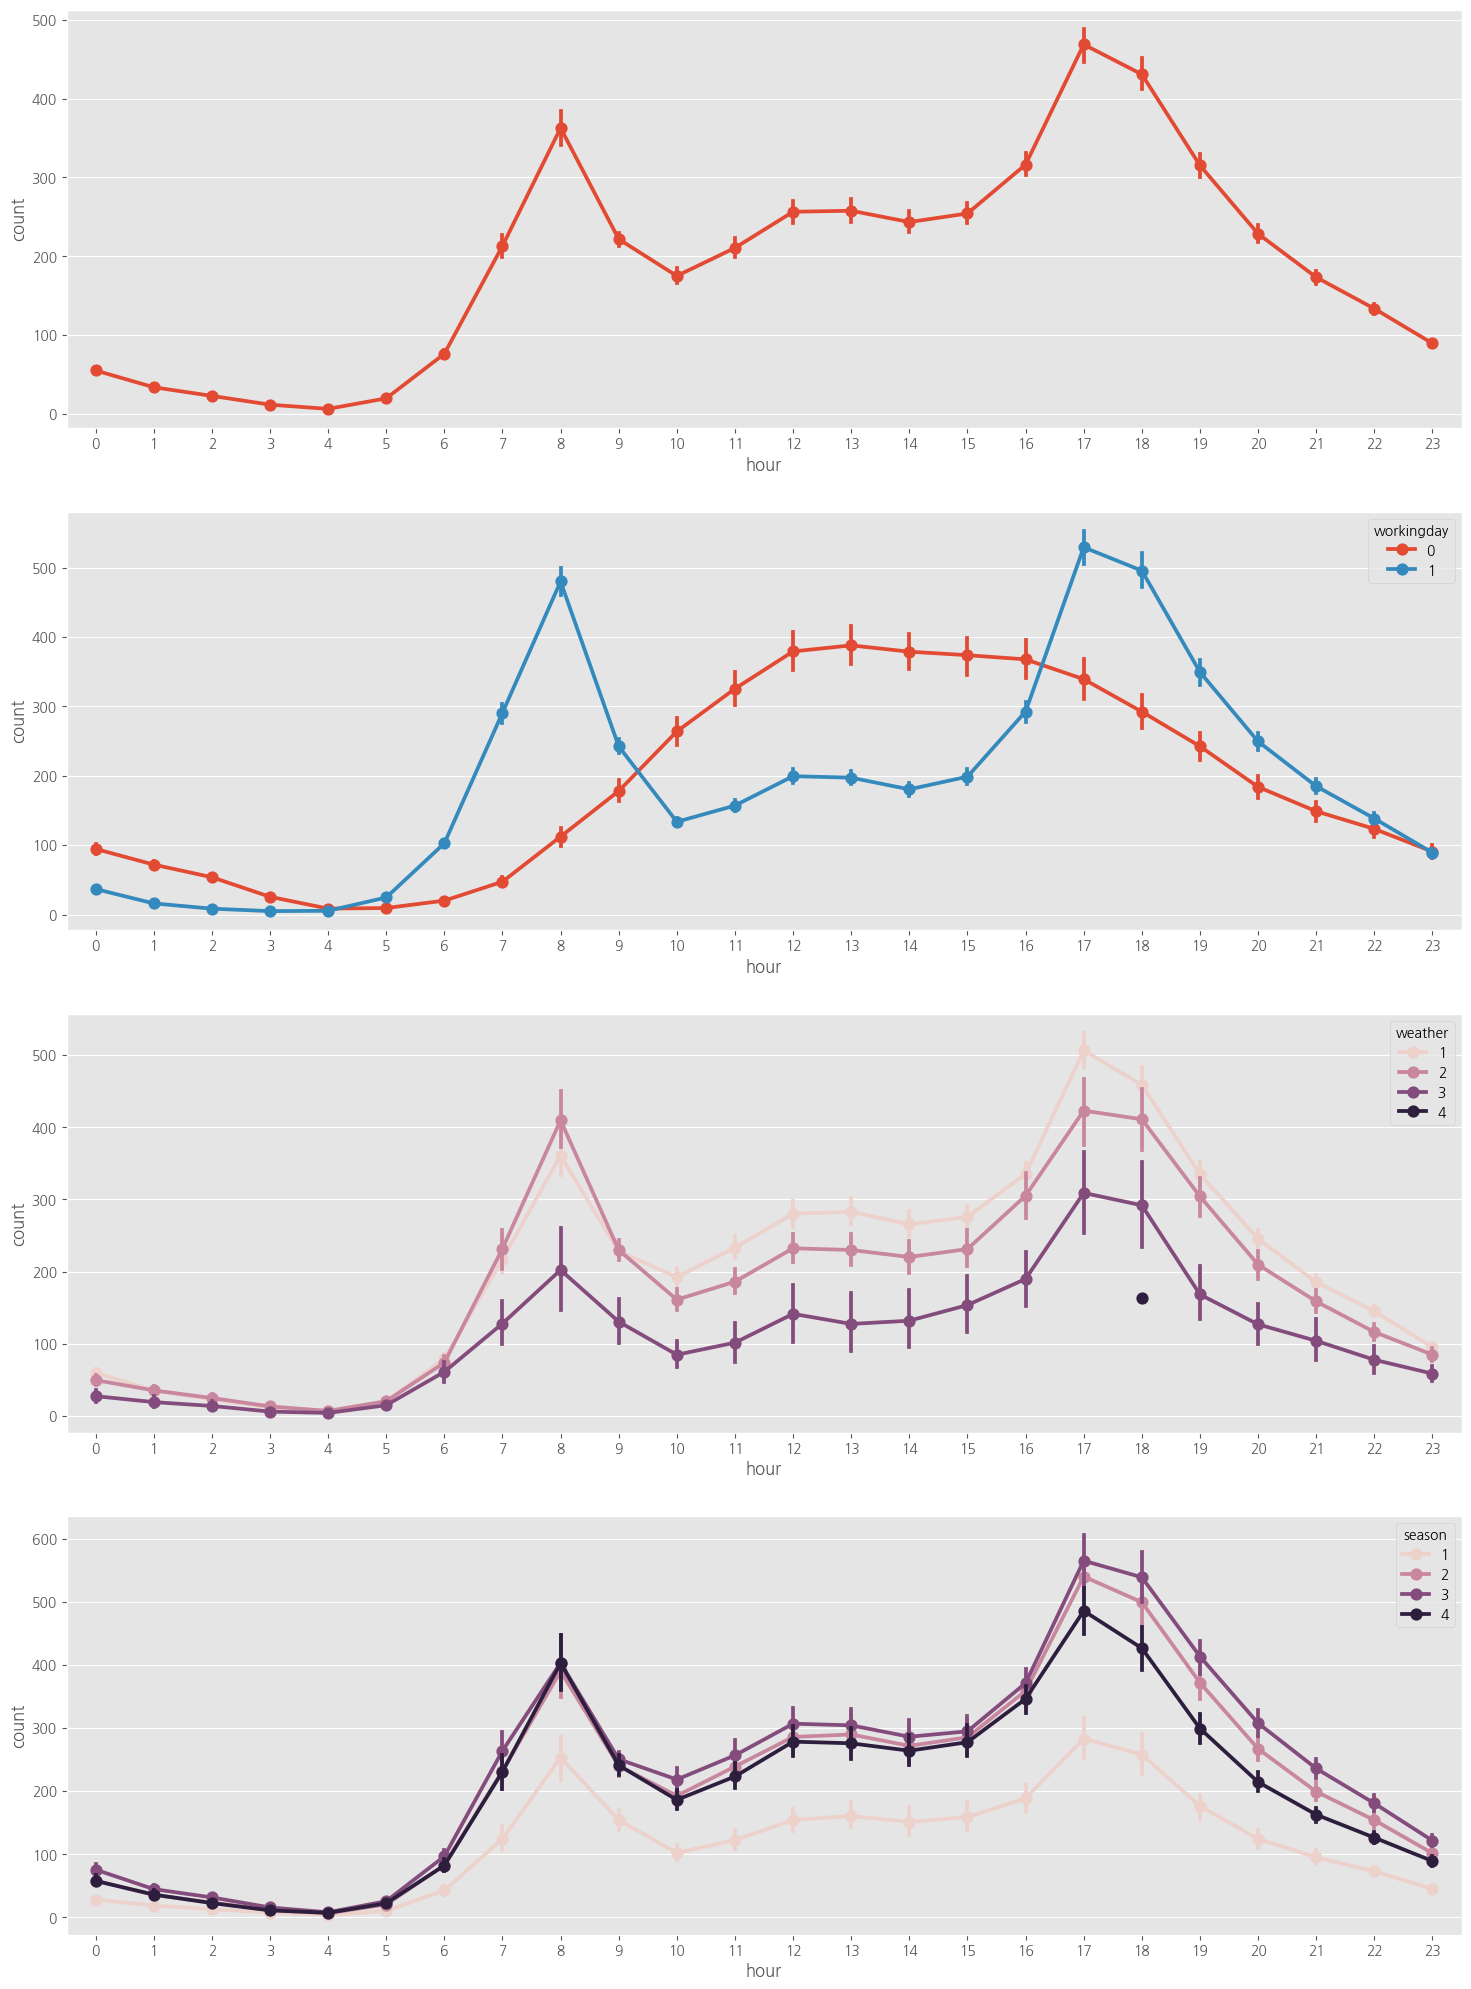

In [13]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18,25)

sns.pointplot(data=train_df, x="hour", y="count", ax=ax1)

sns.pointplot(data=train_df, x="hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train_df, x="hour", y="count", hue="weather", ax=ax3)

sns.pointplot(data=train_df, x="hour", y="count", hue="season", ax=ax4)

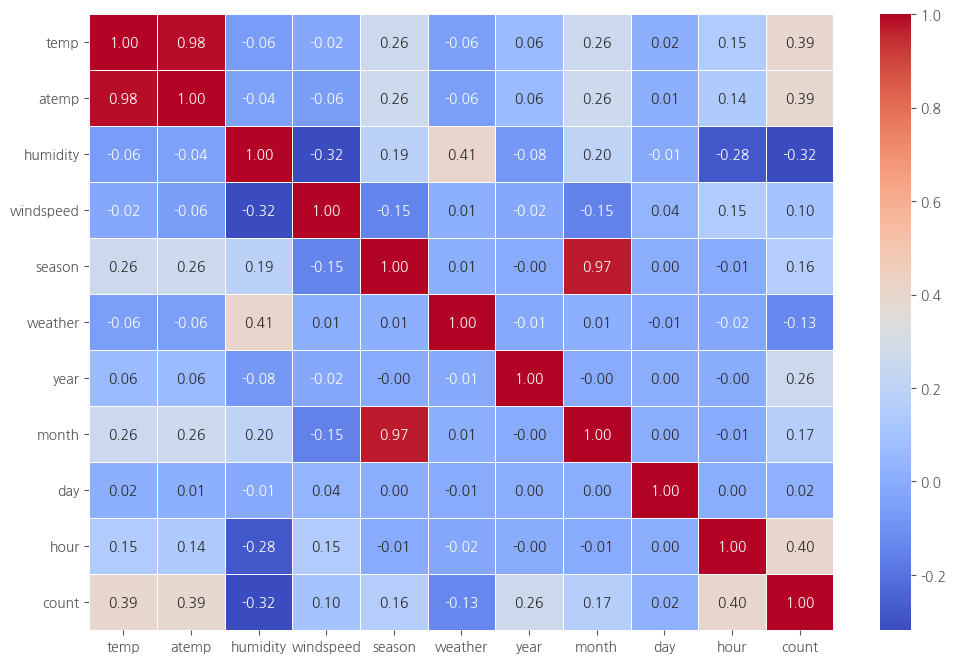

In [14]:
corr_matrix = train_df[["temp", "atemp", "humidity", "windspeed", 'season', 'weather', 'year', 'month', 'day', 'hour', "count"]].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.show()

> - 온도, 습도, 풍속은 거의 연관관계가 없다.
> - atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다. -> 확인 필요

<Axes: xlabel='humidity', ylabel='count'>

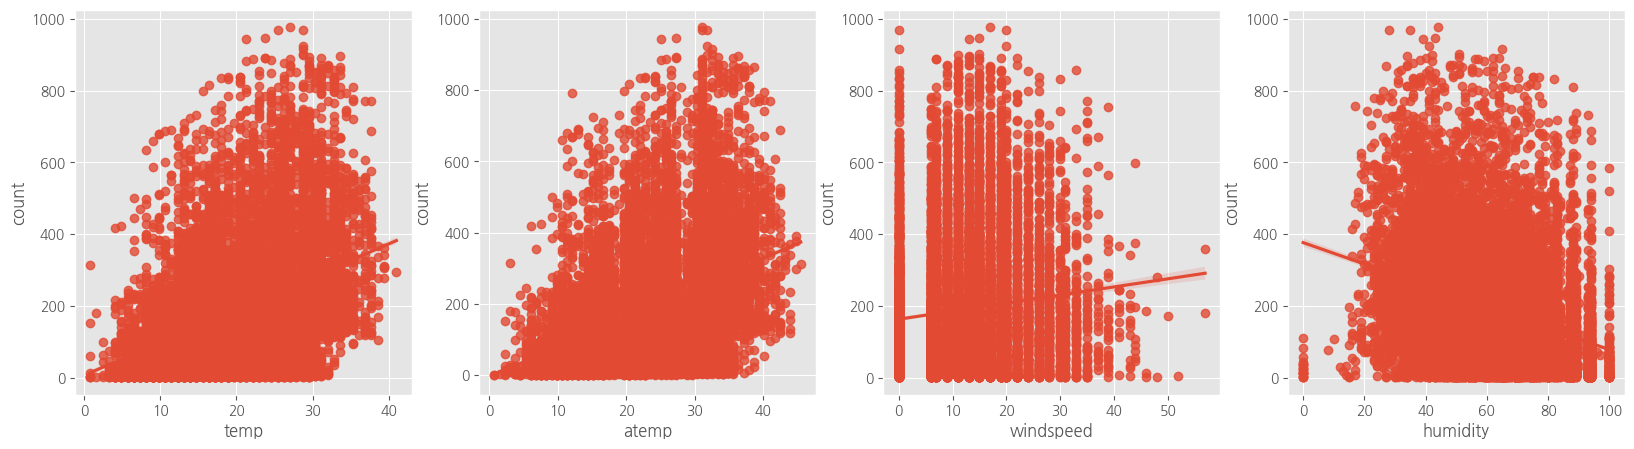

In [15]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
fig.set_size_inches(20, 5)
sns.regplot(x="temp", y="count", data=train_df,ax=ax1)
sns.regplot(x="atemp", y="count", data=train_df,ax=ax2)
sns.regplot(x="windspeed", y="count", data=train_df,ax=ax3)
sns.regplot(x="humidity", y="count", data=train_df,ax=ax4)

<Axes: xlabel='windspeed', ylabel='count'>

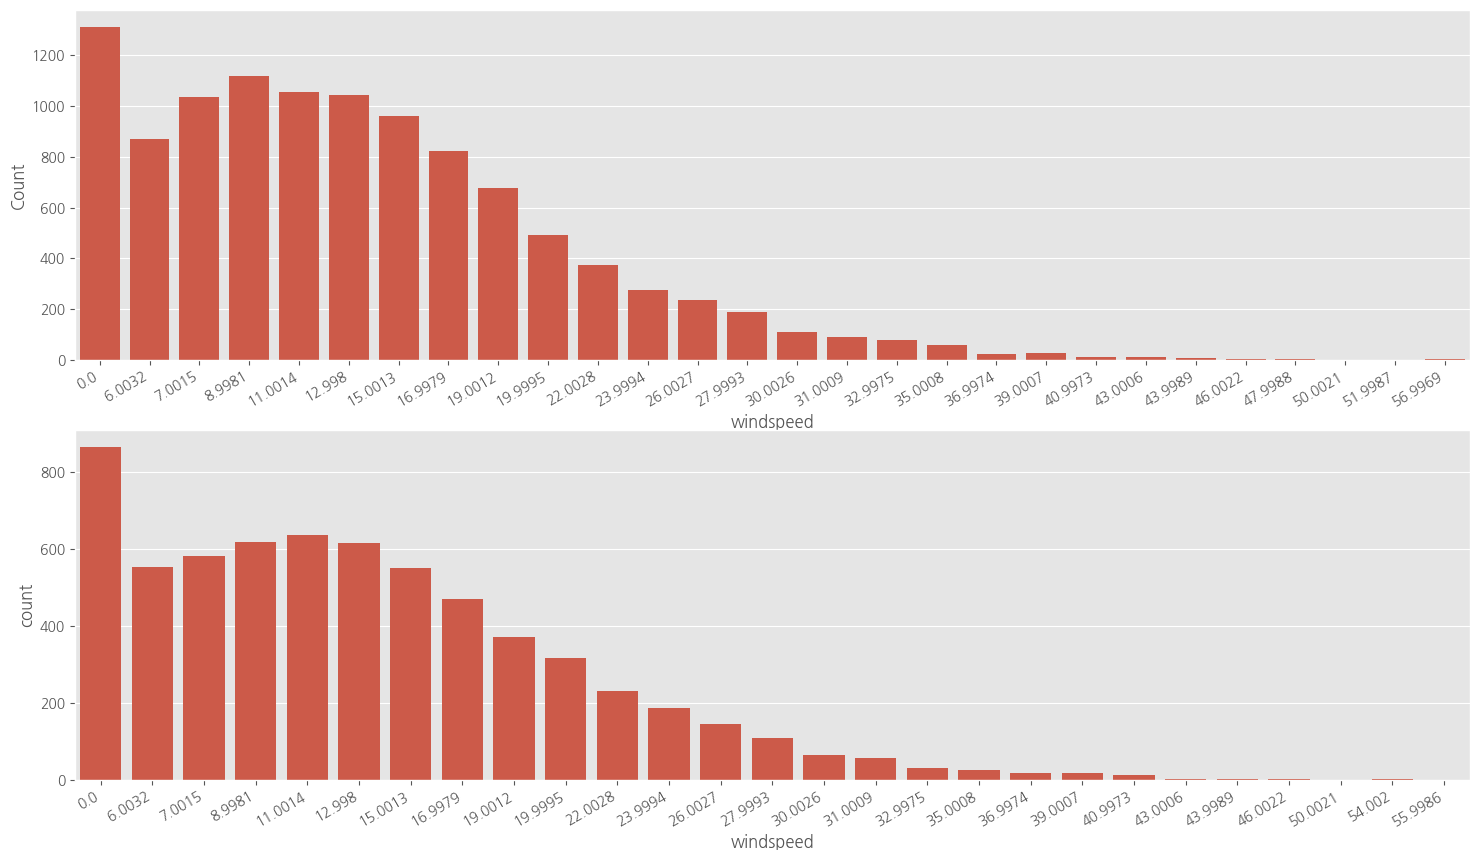

In [16]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18, 10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count')
sns.countplot(data=train_df, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count')
sns.countplot(data=test_df, x='windspeed', ax=axes[1])

> - 풍속 데이터를 시각화를 하면 0에 굉장히 많은 값이 모여있는 것을 확인할 수 있다.
> - 따라서 풍속의 0 값에 특정 값을 넣어줘야 한다.
> - 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 되지 않을 수도 있다.
> - 풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다. 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.

> - 풍속이 0인 것과 아닌 것의 세트를 나누어 예측을 통해 풍속을 구하는 방법

In [17]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train_df["year_month"] = train_df["datetime"].apply(concatenate_year_month)

print(train_df.shape)
train_df[["datetime", "year_month"]].head()

(10886, 17)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<Axes: xlabel='year_month', ylabel='count'>

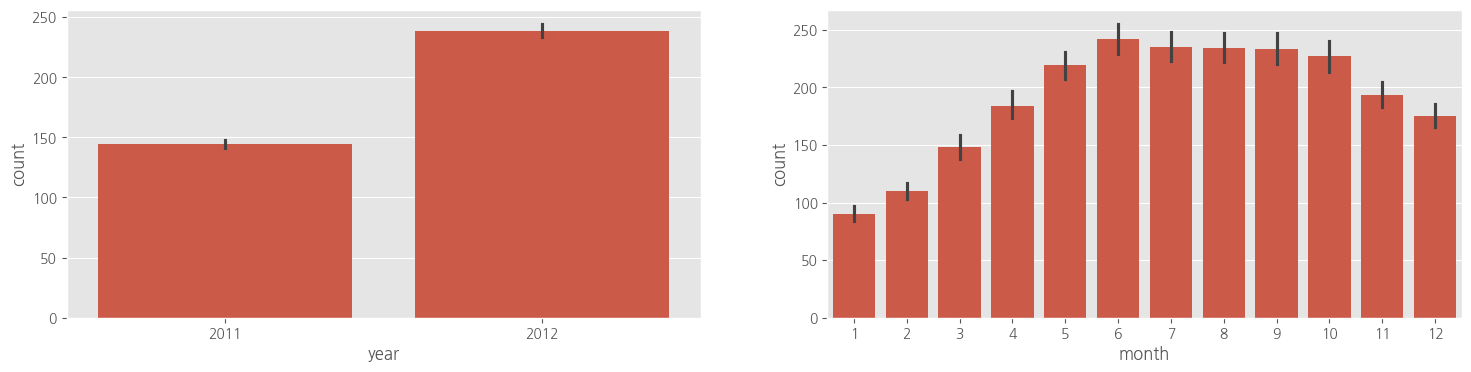

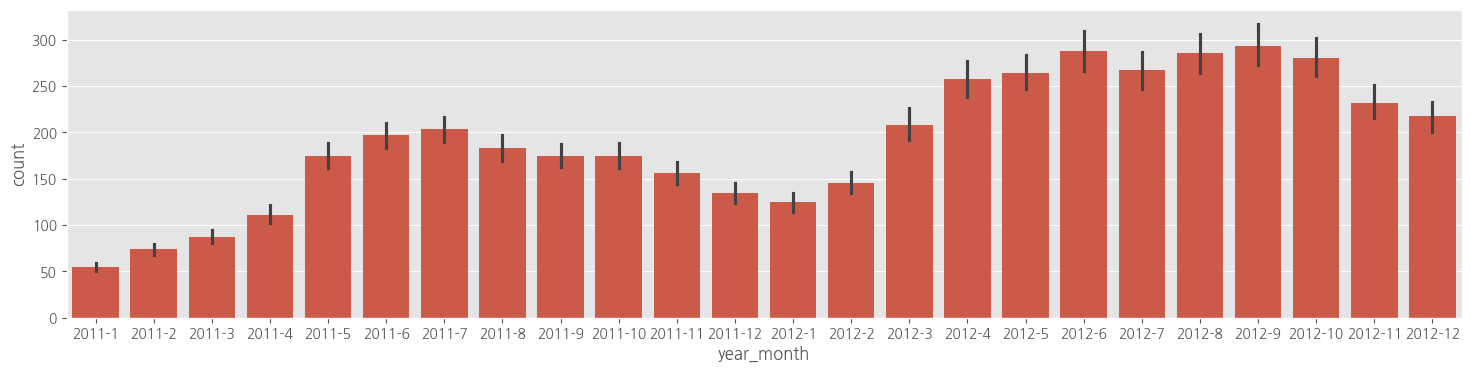

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train_df, x="year", y="count", ax=ax1)
sns.barplot(data=train_df, x="month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=train_df, x="year_month", y="count", ax=ax3)

<Axes: xlabel='year_month', ylabel='count'>

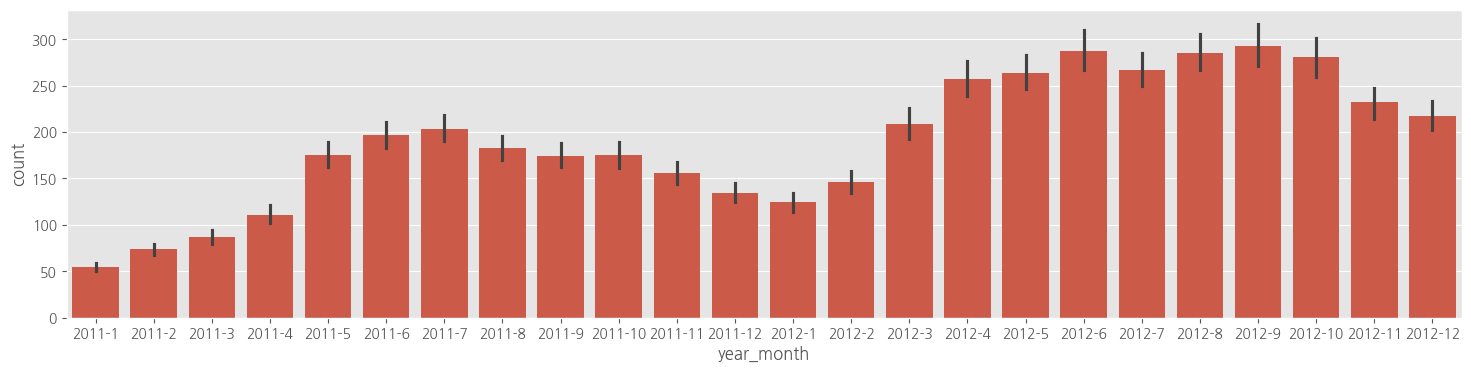

In [19]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)
sns.barplot(data=train_df, x="year_month", y="count", ax=ax1)

> - 2011년보다 2012년의 대여량이 더 많다.
> - 겨울보다는 여름에 대여량이 많다.
> - 2011년과 2012년의 월별 데이터를 이어보면 전체적으로 증가하는 추세이다.

# data cleaning

In [20]:
drop_feature = ['casual', 'registered']
train_df.drop(drop_feature, axis=1, inplace=True)

train_df.drop(['year_month'], axis=1, inplace=True)

train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


In [21]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

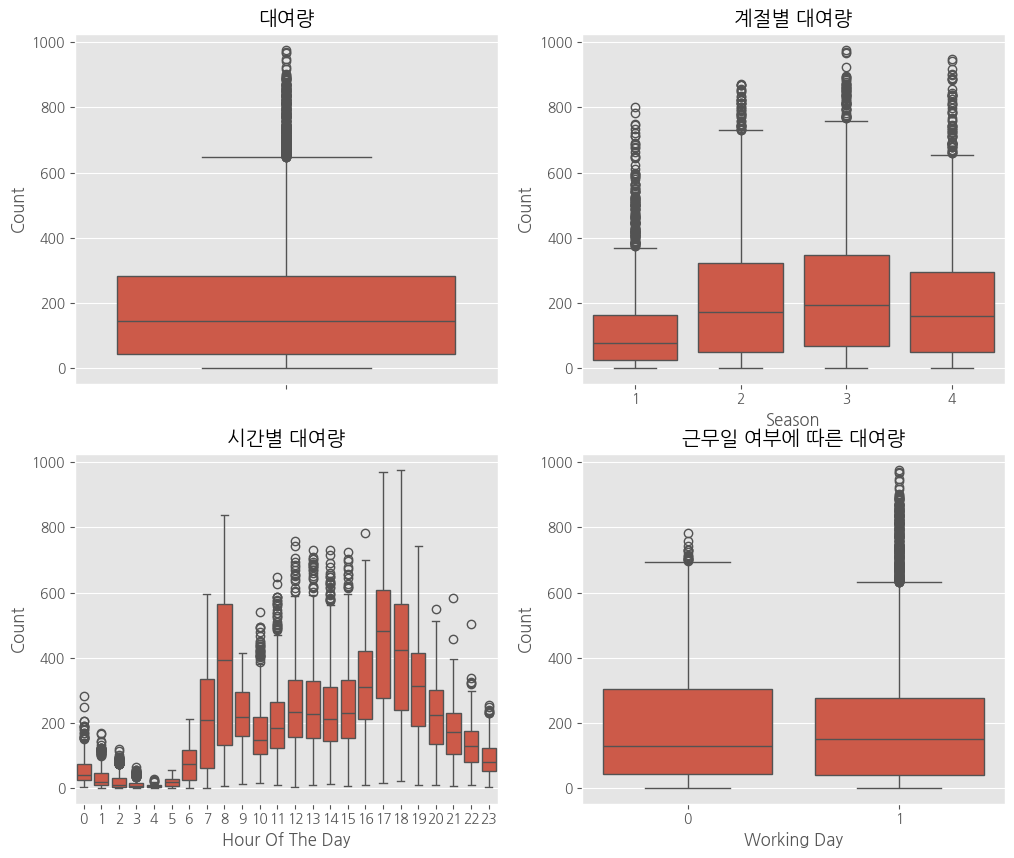

In [22]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train_df,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train_df,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train_df,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train_df,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="대여량")
axes[0][1].set(xlabel='Season', ylabel='Count',title="계절별 대여량")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="시간별 대여량")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="근무일 여부에 따른 대여량")

### train_df에서 count 열의 이상치를 제거한 새로운 데이터프레임 trainWithoutOutliers를 생성하는 코드
> - 표준 편차를 이용하여 count 값이 평균에서 크게 벗어난 값(이상치)을 제거

> - 각 count 값에서 평균을 뺀 후 절대값을 취한다. 이렇게 하면 각 데이터가 평균으로부터 얼마나 떨어져 있는지를 알 수 있다. 음수는 제거되고 모두 양수로 변환.
> - count 열의 표준 편차에 3을 곱한다. 통계적으로, 정규분포에서는 약 99.7%의 데이터가 평균으로부터 3 표준 편차 이내에 위치. 즉, 이 범위를 벗어나는 값들은 이상치일 가능성이 크다.

In [23]:
# trainWithoutOutliers
trainWithoutOutliers = train_df[np.abs(train_df["count"] - train_df["count"].mean()) <= (3*train_df["count"].std())]

print(train_df.shape)
print(trainWithoutOutliers.shape)

(10886, 14)
(10739, 14)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229772, 4.562423868087808, 0.958117678090961))

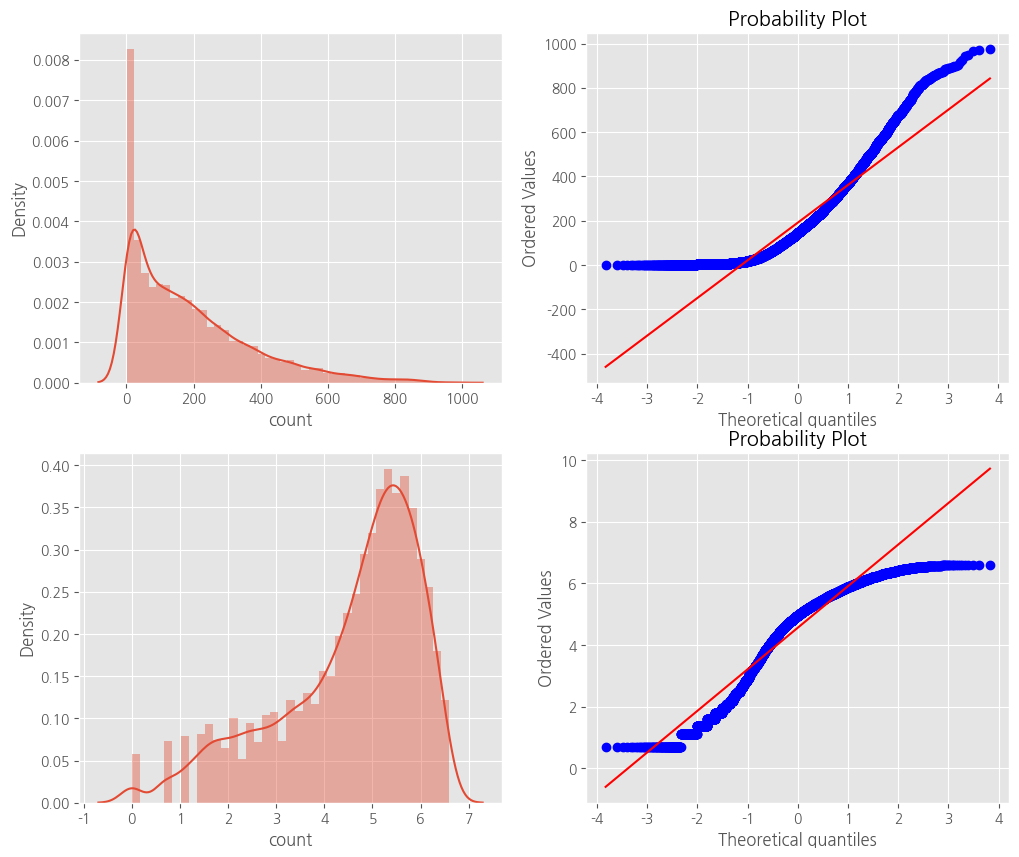

In [24]:
# count값의 데이터 분포도를 파악
figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train_df["count"], ax=axes[0][0])
stats.probplot(train_df["count"], dist='norm', fit=True, plot=axes[0][1])

sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.

In [25]:
# train_df = train_df[np.abs(train_df["count"] - train_df["count"].mean()) <= (3*train_df["count"].std())]

 이상치를 무조건 제거하는 것이 항상 좋은 방법은 아다. 경우에 따라 이상치가 중요한 정보를 포함할 수 있으며, 그럴 경우 삭제보다는 다른 방법(예: 변환, 수정)을 고려해야 함

### feature engineering

In [26]:
# 이미 위에서 작업을 했음
test_df['year'] = test_df.datetime.apply(lambda x: x.year)
test_df['month'] = test_df.datetime.apply(lambda x: x.month)
test_df['day'] = test_df.datetime.apply(lambda x: x.day)
test_df['hour'] = test_df.datetime.apply(lambda x: x.hour)

train_df["dayofweek"] = train_df["datetime"].dt.dayofweek
test_df["dayofweek"] = test_df["datetime"].dt.dayofweek

### dt.dayofweek
> - datetime 열에 있는 날짜 정보를 사용하여 요일을 새로운 열 dayofweek에 추가하는 코드
> - train_df["datetime"] 열에서 날짜 정보를 기반으로 요일을 숫자로 변환하여 새로운 열 dayofweek에 저장

> - 0: 월요일 (Monday)
> - 1: 화요일 (Tuesday)
> - 2: 수요일 (Wednesday)
> - 3: 목요일 (Thursday)
> - 4: 금요일 (Friday)
> - 5: 토요일 (Saturday)
> - 6: 일요일 (Sunday)

<Axes: xlabel='hour', ylabel='count'>

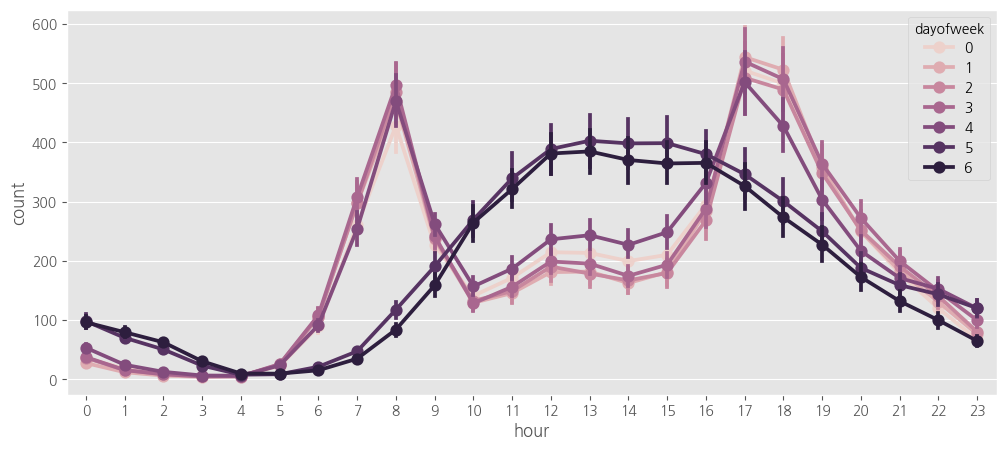

In [27]:
fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(12,5)

sns.pointplot(data=train_df, x="hour", y="count", hue="dayofweek", ax=ax1)

In [28]:
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,2
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,2
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,2
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,2


In [29]:
test_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19,0
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20,0
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21,0
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22,0


In [30]:
trainWind0 = train_df.loc[train_df['windspeed'] == 0]
trainWind1 = train_df.loc[train_df['windspeed'] != 0]

RandomForestClassifier를 사용하여 풍속(windspeed)을 예측하려고 하면, 실제로는 연속형 수치 데이터인 풍속을 여러 개의 **클래스(카테고리)**로 변환해 예측하는 방식으로 동작하게 됩니다. 즉, 풍속을 정확한 값으로 예측하는 대신, 풍속 범위를 여러 개의 이산적인 클래스로 보고 그 중 하나를 예측하는 것입니다. 이는 풍속 예측처럼 연속형 데이터를 다룰 때는 적합하지 않은 방법일 수 있습니다.

In [31]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier

def predict_windspeed(data):
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWind1 = data.loc[data['windspeed'] != 0]

    # 풍속을 예측할 feature
    wcol = ['season', 'weather', 'temp', 'atemp', 'humidity', 'year', 'month', 'hour', 'dayofweek']
    # wcol = ['season', 'weather', 'temp', 'atemp', 'humidity', 'year', 'month']

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWind1['windspeed'] = dataWind1['windspeed'].astype('str')

    # rf = RandomForestClassifier()
    # rf = RandomForestRegressor()
    # rf = XGBRegressor()
    rf = CatBoostClassifier(verbose=False)
    # rf = CatBoostRegressor(verbose=False)
    
    rf.fit(dataWind1[wcol], dataWind1["windspeed"])
    windvalues = rf.predict(dataWind0[wcol])

    # windvalues의 차원을 1차원으로 변환
    windvalues = windvalues.ravel()

    predictWind0 = dataWind0
    predictWind1 = dataWind1

    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0['windspeed'] = windvalues
    # 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = pd.concat([predictWind1, predictWind0])

    data['windspeed'] = data['windspeed'].astype('float')

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

<Axes: title={'center': 'train_df windspeed'}, xlabel='windspeed', ylabel='Count'>

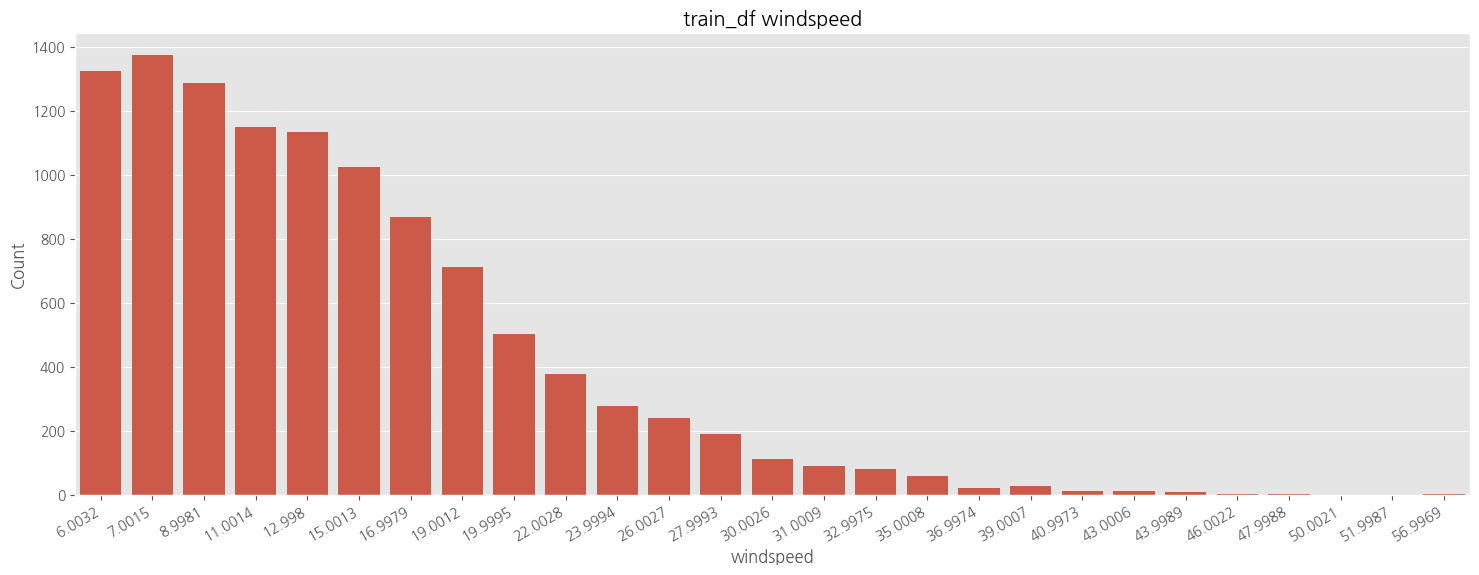

In [32]:
train_df = predict_windspeed(train_df)

fig, axl = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(axl)
plt.xticks(rotation=30, ha='right')
axl.set(ylabel='Count', title='train_df windspeed')
sns.countplot(data=train_df, x="windspeed", ax=axl)

## Feature Selection
> - 신호와 잡음을 구분해야 한다.
> - 피처가 많다고 무조건 좋은 성능을 내지 않는다.
> - 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [33]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,1,2011,1,1,5,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,36,2011,1,1,10,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,56,2011,1,1,11,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,84,2011,1,1,12,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,94,2011,1,1,13,5


In [34]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


In [35]:
# 연속형 feature = ['temp', 'atemp', 'humidity', 'windspeed']

In [36]:
train_df['year'] = train_df['year'].replace({2011: 0, 2012: 1})
test_df['year'] = test_df['year'].replace({2011: 0, 2012: 1})

In [37]:
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,1,0,1,1,5,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,36,0,1,1,10,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,56,0,1,1,11,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,84,0,1,1,12,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,94,0,1,1,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-17 12:00:00,4,0,1,2,16.40,20.455,87,6.0032,232,1,12,17,12,0
10882,2012-12-17 15:00:00,4,0,1,2,17.22,21.210,88,8.9981,211,1,12,17,15,0
10883,2012-12-18 08:00:00,4,0,1,1,15.58,19.695,94,6.0032,662,1,12,18,8,1
10884,2012-12-18 22:00:00,4,0,1,1,13.94,16.665,49,15.0013,132,1,12,18,22,1


In [38]:
categorical_feature = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'hour', 'dayofweek']

for i in categorical_feature:
    train_df[i] = train_df[i].astype('category')
    test_df[i] = test_df[i].astype('category')

In [39]:
feature_names = ["season", "holiday", "workingday", "weather", "temp", "atemp", "humidity", "windspeed", #'month', # month 추가
                 "year", "hour", "dayofweek"]
feature_names

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek']

In [40]:
X = train_df[feature_names]
y = train_df["count"]
X.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,0,2,9.84,12.880,75,6.0032,0,5,5
1,1,0,0,1,15.58,19.695,76,16.9979,0,10,5
2,1,0,0,1,14.76,16.665,81,19.0012,0,11,5
3,1,0,0,1,17.22,21.210,77,19.0012,0,12,5
4,1,0,0,2,18.86,22.725,72,19.9995,0,13,5


In [41]:
test_df = test_df[feature_names]
print(test_df.shape)
test_df.head()

(6493, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,0,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,0,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,0,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,0,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,0,4,3


In [42]:
s

NameError: name 's' is not defined

### RandomForest

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
model

In [ ]:
%time
score = cross_val_score(model, X, y, cv=k_fold, scoring=scores)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

In [ ]:
model.fit(X, y)

In [ ]:
# 예측
predictions = model.predict(test_df)

print(predictions.shape)
predictions[0:10]

In [ ]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y,ax=ax1,bins=50)
ax1.set(title="train")

sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [ ]:
importances = model.feature_importances_
features = test_df.columns  # 또는 학습에 사용한 feature names

# 피처 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 중요도 출력
print(feature_importance_df)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # 중요도가 높은 것이 위로 오도록 반전
plt.show()

In [ ]:
submission = pd.read_csv("../../data/bike/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

In [ ]:
submission.to_csv("submission.csv".format(score), index=False)

In [ ]:
s

## catboost

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
cat_feature = ['season', 'holiday', 'workingday', 'weather', 'year', 'hour', 'dayofweek']
cat = CatBoostRegressor(n_estimators=100, random_state=0, verbose=False, cat_features= cat_feature)

In [ ]:
%time
score = cross_val_score(cat, X, y, cv=k_fold, scoring=scores)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

In [ ]:
cat.fit(X, y)

In [ ]:
predictions = cat.predict(test_df)

print(predictions.shape)
predictions[0:10]

In [ ]:
submission = pd.read_csv("../../data/bike/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

In [ ]:
submission.to_csv("submission_cat.csv".format(score), index=False)

In [ ]:
s

# XGBoost

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
categorical_feature = ['season', 'holiday', 'workingday', 'weather', 'year', 'hour', 'dayofweek']
X_encoded = pd.get_dummies(X, columns=categorical_feature, drop_first=False)
test_encoded = pd.get_dummies(test_df, columns=categorical_feature, drop_first=False)

xgb = XGBRegressor(n_estimators=100, random_state=0, verbose=False)

In [ ]:
%time
score = cross_val_score(xgb, X_encoded, y, cv=k_fold, scoring=scores)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

In [ ]:
xgb.fit(X_encoded, y)

In [ ]:
predictions = xgb.predict(test_encoded)

print(predictions.shape)
predictions[0:10]

In [ ]:
predictions = np.clip(predictions, 0, None)

In [ ]:
submission = pd.read_csv("../../data/bike/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

In [ ]:
submission.to_csv("submission_xgb.csv".format(score), index=False)

In [ ]:
s

# 로그 변환

In [43]:
y_log = np.log1p(y)

In [ ]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y,ax=ax1,bins=50)
ax1.set(title="로그 변환 전")

sns.distplot(y_log,ax=ax2,bins=50)
ax2.set(title="로그 변환 후")

In [61]:
rfModel = RandomForestRegressor(n_estimators=200)

In [62]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [63]:
%time
score = cross_val_score(rfModel, X, y_log, cv=k_fold, scoring=scores)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 5.72 μs
RMSLE: 0.077, RMSE: 0.283, MAE: 0.194
RMSLE: 0.088, RMSE: 0.318, MAE: 0.214
RMSLE: 0.082, RMSE: 0.297, MAE: 0.203
RMSLE: 0.076, RMSE: 0.293, MAE: 0.197
RMSLE: 0.075, RMSE: 0.301, MAE: 0.199
RMSLE: 0.085, RMSE: 0.311, MAE: 0.203
RMSLE: 0.082, RMSE: 0.310, MAE: 0.202
RMSLE: 0.074, RMSE: 0.289, MAE: 0.196
RMSLE: 0.091, RMSE: 0.320, MAE: 0.210
RMSLE: 0.087, RMSE: 0.319, MAE: 0.208
Score= 0.08182


In [64]:
rfModel.fit(X, y_log)

RandomForestRegressor(n_estimators=200)

In [65]:
preds = rfModel.predict(X)
score = rmsle(np.exp(y_log),np.exp(preds))
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10534112631045482


In [66]:
predsTest = rfModel.predict(test_df)

In [67]:
submission = pd.read_csv("../../data/bike/sampleSubmission.csv")
submission["count"] = np.exp(predsTest)

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.542689
1,2011-01-20 01:00:00,5.868356
2,2011-01-20 02:00:00,4.112805
3,2011-01-20 03:00:00,4.366640
4,2011-01-20 04:00:00,3.654742


In [68]:
submission.to_csv("submission_best.csv".format(score), index=False)

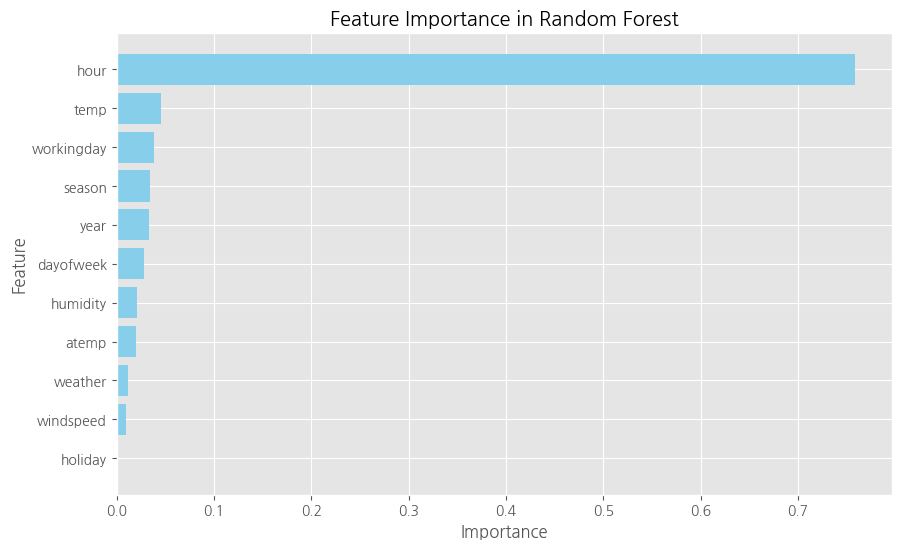

In [69]:
importances = rfModel.feature_importances_
features = test_df.columns  # 또는 학습에 사용한 feature names

# 피처 중요도를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # 중요도가 높은 것이 위로 오도록 반전
plt.show()

In [70]:
195/3243

0.060129509713228495

In [56]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y)
rfModel.fit(X, y_train_log)

preds = rfModel.predict(X)
score = rmsle(np.exp(y_train_log),np.exp(preds))
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10633316899033564


In [58]:
predsTest = rfModel.predict(test_df)

In [59]:
submission = pd.read_csv("../../data/bike/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.136365
1,2011-01-20 01:00:00,5.826467
2,2011-01-20 02:00:00,4.159756
3,2011-01-20 03:00:00,4.227425
4,2011-01-20 04:00:00,3.789461


In [60]:
submission.to_csv("submission_best.csv".format(score), index=False)

## CatBoost

In [98]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [99]:
cat_feature = ['season', 'holiday', 'workingday', 'weather', 'year', 'hour', 'dayofweek']
cat = CatBoostRegressor(n_estimators=100, random_state=0, verbose=False, cat_features= cat_feature)

In [100]:
%time
score = cross_val_score(cat, X, y_log, cv=k_fold, scoring=scores)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 4 μs, sys: 3 μs, total: 7 μs
Wall time: 14.1 μs
RMSLE: 0.129, RMSE: 0.504, MAE: 0.364
RMSLE: 0.135, RMSE: 0.522, MAE: 0.381
RMSLE: 0.141, RMSE: 0.559, MAE: 0.404
RMSLE: 0.126, RMSE: 0.532, MAE: 0.396
RMSLE: 0.126, RMSE: 0.519, MAE: 0.382
RMSLE: 0.141, RMSE: 0.561, MAE: 0.406
RMSLE: 0.130, RMSE: 0.532, MAE: 0.379
RMSLE: 0.134, RMSE: 0.535, MAE: 0.393
RMSLE: 0.131, RMSE: 0.510, MAE: 0.363
RMSLE: 0.145, RMSE: 0.561, MAE: 0.395
Score= 0.13382


In [101]:
cat.fit(X, y_log)

In [102]:
preds = cat.predict(X)
score = rmsle(np.exp(y_log),np.exp(preds))
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.4974882759886714


In [103]:
predsTest = cat.predict(test_df)

In [104]:
submission = pd.read_csv("../../data/bike/sampleSubmission.csv")
submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,5.373179
1,2011-01-20 01:00:00,5.807700
2,2011-01-20 02:00:00,5.807700
3,2011-01-20 03:00:00,5.205298
4,2011-01-20 04:00:00,5.205298


In [105]:
submission.to_csv("submission_cat_best.csv".format(score), index=False)

# XGBoost

In [84]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [85]:
categorical_feature = ['season', 'holiday', 'workingday', 'weather', 'year', 'hour', 'dayofweek']
X_encoded = pd.get_dummies(X, columns=categorical_feature, drop_first=False)
test_encoded = pd.get_dummies(test_df, columns=categorical_feature, drop_first=False)

xgb = XGBRegressor(n_estimators=100, random_state=0, verbose=False)

In [86]:
%time
score = cross_val_score(xgb, X_encoded, y_log, cv=k_fold, scoring=scores)
score = score.mean()

# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 4 μs, sys: 3 μs, total: 7 μs
Wall time: 13.1 μs
RMSLE: 0.078, RMSE: 0.298, MAE: 0.209
RMSLE: 0.089, RMSE: 0.328, MAE: 0.226
RMSLE: 0.090, RMSE: 0.334, MAE: 0.228
RMSLE: 0.077, RMSE: 0.307, MAE: 0.215
RMSLE: 0.083, RMSE: 0.325, MAE: 0.221
RMSLE: 0.086, RMSE: 0.321, MAE: 0.223
RMSLE: 0.085, RMSE: 0.321, MAE: 0.215
RMSLE: 0.077, RMSE: 0.305, MAE: 0.215
RMSLE: 0.092, RMSE: 0.326, MAE: 0.222
RMSLE: 0.084, RMSE: 0.313, MAE: 0.213
Score= 0.08421


In [90]:
xgb.fit(X_encoded, y_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [92]:
preds = xgb.predict(X_encoded)
score = rmsle(np.exp(y_log),np.exp(preds))
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.182843222434541


In [93]:
predsTest = xgb.predict(test_encoded)

In [94]:
submission = pd.read_csv("../../data/bike/sampleSubmission.csv")
submission["count"] = np.exp(predsTest)

In [96]:
submission.to_csv("submission_xgb_best.csv".format(score), index=False)

In [97]:
182/3243

0.056120875732346594